# Rooster：客戶行為與渠道效益分析 Notebook

本 Notebook 對應 A2 報告的分析流程，包含資料載入、清理、描述性分析與基礎預測建模。  
建議搭配文字報告一起閱讀：Notebook 著重「怎麼做」，報告負責說明「做了什麼」與「為什麼重要」。

## 0. 環境設定與套件安裝

在本機或 Colab 若尚未安裝套件，可以先在「終端機」或單獨一個 Code cell 執行下列指令；  
若環境已安裝好，可略過此步驟。

In [1]:
pip install pycaret==3.3.2 pandas==2.1.4 seaborn==0.13.2 matplotlib==3.7.5 numpy==1.26.4 openpyxl==3.1.5

Note: you may need to restart the kernel to use updated packages.


## 1. 載入套件與原始資料

讀取 `rooster_a2.xlsx` 中的四個工作表，並檢查基本結構。

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pycaret.classification import *

# 統一圖表風格（方便截圖貼到報告 / 投影片）
sns.set_theme(style="white", rc={"figure.figsize": (12, 6)})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.0})

file_path = "rooster_a2.xlsx"  # 若路徑不同，請在此處修改

products   = pd.read_excel(file_path, sheet_name="products")
orders     = pd.read_excel(file_path, sheet_name="orders")
orderlines = pd.read_excel(file_path, sheet_name="orderlines")
customers  = pd.read_excel(file_path, sheet_name="customers")

shape_summary = pd.DataFrame({
    "Dataset": ["products", "orders", "orderlines", "customers"],
    "Rows":    [products.shape[0], orders.shape[0], orderlines.shape[0], customers.shape[0]],
    "Columns": [products.shape[1], orders.shape[1], orderlines.shape[1], customers.shape[1]],
})
shape_summary.index = shape_summary.index + 1

print("=== Dataset Shape Summary ===")
display(shape_summary)


=== Dataset Shape Summary ===


,Dataset,Rows,Columns
1,products,226,12
2,orders,10541,16
3,orderlines,27795,8
4,customers,8465,5


In [18]:
# 列出各資料集的欄位名稱，並編號以方便後續參考
def print_numbered_columns(df, name):
    print(f"=== {name} ===")
    for idx, col in enumerate(df.columns, start=1):
        print(f"{idx}. {col}")
    print("\n")

print_numbered_columns(orders, "orders")
print_numbered_columns(orderlines, "orderlines")
print_numbered_columns(products, "products")
print_numbered_columns(customers, "customers")

=== orders ===
1. order_number
2. customer_email
3. order_date
4. payment_method_title
5. shipping_method_title
6. coupon_code
7. coupon_count
8. origin
9. order_subtotal
10. order_total
11. order_total_tax
12. order_shipping
13. order_refund
14. cart_discount
15. discount_amount
16. discount_amount_tax


=== orderlines ===
1. order_number
2. product_id
3. variation_id
4. sku
5. line_id
6. qty_minus_refund
7. item_price
8. item_price_before_discount


=== products ===
1. product_id
2. range
3. product_type
4. category
5. product_name_main
6. product_name
7. size
8. variation_id
9. sku
10. price
11. type
12. colour


=== customers ===
1. billing_email
2. customer_first_order_date
3. customer_last_order_date
4. customer_total_orders
5. customer_total_spent




=== order_total 描述統計 ===


count    10541.00
mean        45.63
std         28.82
min          0.00
25%         20.80
50%         40.41
75%         55.20
max        304.20
Name: order_total, dtype: object

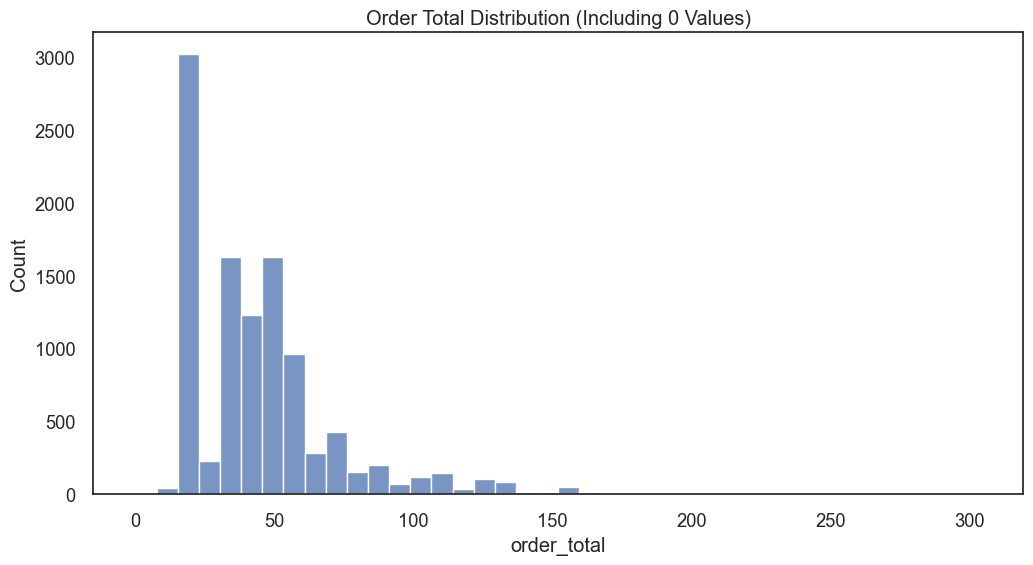

In [ ]:
# 1.3.1 訂單金額描述統計與分布
orders["order_total"] = pd.to_numeric(orders["order_total"], errors="coerce")
order_total_desc = orders["order_total"].describe()
print("=== order_total 描述統計 ===")
display(order_total_desc.map('{:.2f}'.format))

sns.histplot(data=orders, x="order_total", bins=40)
plt.title("Order Total Distribution (Including 0 Values)")
plt.xlabel("order_total")
plt.ylabel("Count")
plt.show()

In [20]:
# 檢查 order_total = 0 並建立清洗版 orders_clean
zero_orders = orders[orders["order_total"] == 0]
print(f"order_total = 0 的訂單筆數：{len(zero_orders)}")
display(zero_orders.head())

orders_clean = orders[orders["order_total"] > 0].copy()
orders_clean["coupon_used"] = orders_clean["coupon_code"].notna()
orders_clean["order_date"] = pd.to_datetime(orders_clean["order_date"])
print(f"清洗後訂單筆數：{len(orders_clean)}")

order_total = 0 的訂單筆數：8


,order_number,customer_email,order_date,payment_method_title,shipping_method_title,coupon_code,coupon_count,origin,order_subtotal,order_total,order_total_tax,order_shipping,order_refund,cart_discount,discount_amount,discount_amount_tax
6501,ord_470aefe4,eml_a5eff54f@gmail.example.net,2024-10-14 17:55,NaN,NaN,PROMO100,1,Google,83.33,0.0,0.0,0.0,0.0,83.333333,83.33,16.67
7246,ord_3fb41b2d,eml_7b6ccaae@gmail.example.net,2024-11-10 18:55,NaN,NaN,PROMO10,1,Direct,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67
7256,ord_18a79c76,eml_2c768f80@gmail.example.net,2024-11-10 21:48,NaN,NaN,VOUCHER10,1,Google,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67
7260,ord_13d46568,eml_1b3c1c7c@gmail.example.net,2024-11-10 23:25,NaN,Packet - Courier,PROMO100,1,Newsletter,12.42,0.0,0.0,0.0,0.0,12.416667,12.42,2.48
7267,ord_55182f9f,eml_2c768f80@gmail.example.net,2024-11-11 09:06,NaN,NaN,VOUCHER10,1,Google,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67


清洗後訂單筆數：10533


coupon_used 比例：


coupon_used
False    71.0%
True     29.0%
Name: proportion, dtype: object

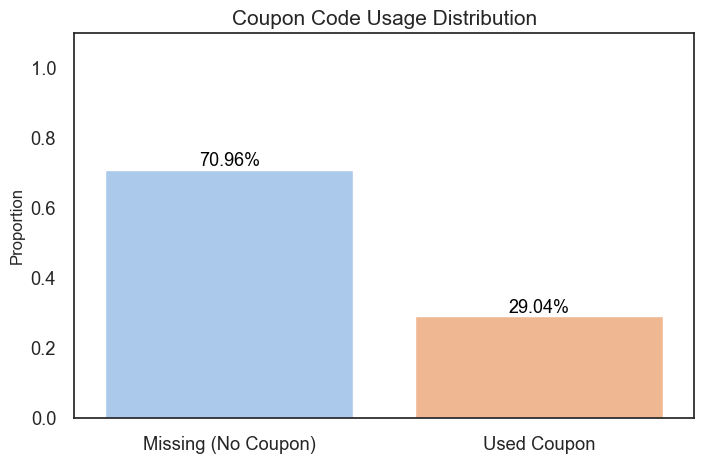

In [28]:
# 1.3.2 優惠券欄位缺失比例與重新編碼
print("coupon_used 比例：")
display(
    orders_clean["coupon_used"]
    .value_counts(normalize=True)
    .rename("proportion")
    .map('{:.1%}'.format)
)

df_plot = orders["coupon_code"].isna().value_counts(normalize=True).reset_index()
df_plot.columns = ["Is_Missing", "Proportion"]

# 為了圖表好讀，把 True/False 換成文字標籤
df_plot["Label"] = df_plot["Is_Missing"].map({
    True: "Missing (No Coupon)", 
    False: "Used Coupon"
})

# 開始畫圖
plt.figure(figsize=(8, 5)) # 設定圖片大小

# 使用 seaborn 畫長條圖
ax = sns.barplot(data=df_plot, x="Label", y="Proportion", palette="pastel")

# 設定標題與軸標籤
plt.title("Coupon Code Usage Distribution", fontsize=15)
plt.ylabel("Proportion", fontsize=12)
plt.xlabel("") # X軸標籤可以留空，因為 Label 已經很清楚了

# 重點步驟：在柱子上加上數值標籤 (設定 2 位小數)
# 這段迴圈會抓出每一根柱子的高度，並把數字寫上去
for p in ax.patches:
    height = p.get_height() # 取得柱子高度 (例如 0.7101...)
    ax.text(
        x = p.get_x() + p.get_width() / 2,  # 文字的 X 座標 (柱子中心)
        y = height + 0.01,                  # 文字的 Y 座標 (柱子頂端再高一點點)
        s = f'{height:.2%}',                # <--- 這裡設定顯示格式：百分比 + 2位小數
        ha = 'center',                      # 水平置中
        fontsize=13,                        # 字體大小
        color='black'
    )

# 調整 Y 軸範圍，讓頂端的字不會被切掉
plt.ylim(0, 1.1) 

plt.show()

## 3. 訂單層級：渠道 × 訂單金額

使用 `orders_clean`（已排除 0 元訂單）觀察不同來源 `origin` 的訂單金額分布與中位數。

👉 **Tableau 圖建議：**

- 使用 `origin_summary` 做 Bar chart：Median order_total by origin
- 可以放在 Dashboard 左上角，對應報告 2.4 小節

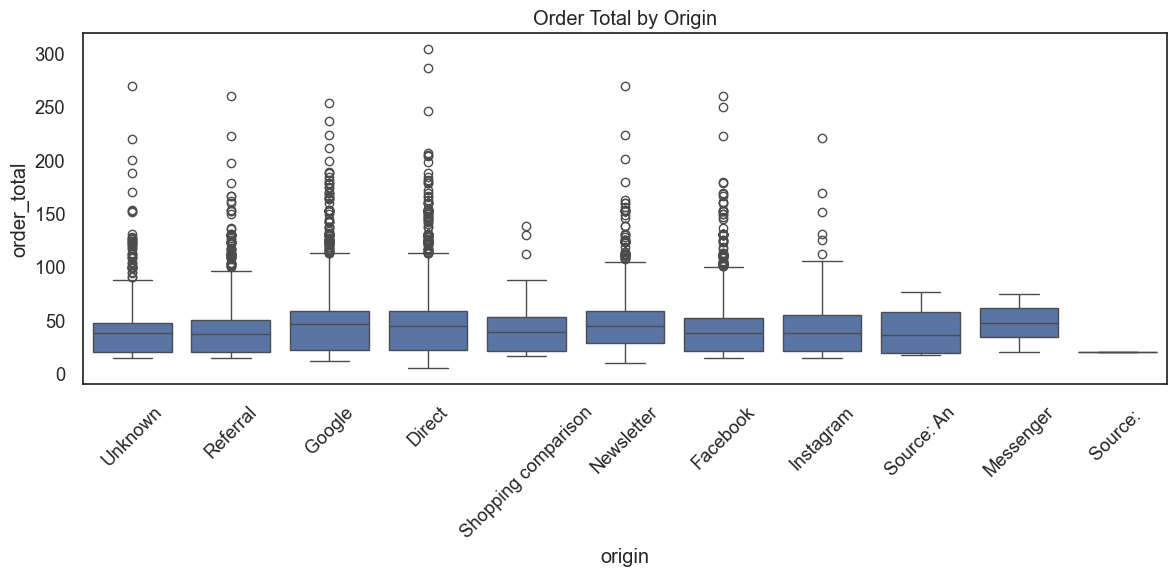

origin
Google                 0.225880
Direct                 0.225121
Facebook               0.188787
Unknown                0.130253
Referral               0.117636
Newsletter             0.072479
Shopping comparison    0.023622
Instagram              0.015558
Source: An             0.000379
Messenger              0.000190
Source:                0.000095
Name: proportion, dtype: float64
origin_grouped
Google                 0.225482
Direct                 0.225197
Facebook               0.188930
Unknown                0.130352
Referral               0.117725
Newsletter             0.072439
Shopping comparison    0.023640
Instagram              0.015570
Other                  0.000665
Name: proportion, dtype: float64


In [36]:
# 3.1 boxplot：不同來源的訂單金額分布
sns.boxplot(data=orders_clean, x="origin", y="order_total")
plt.xticks(rotation=45)
plt.title("Order Total by Origin")
plt.xlabel("origin")
plt.ylabel("order_total")
plt.tight_layout()
plt.show()

# 檢查各渠道的佔比
print(orders["origin"].value_counts(normalize=True))

# 定義要保留的主要渠道 (例如前 8 名)
top_channels = orders["origin"].value_counts().nlargest(8).index

# 將不在前 8 名的都歸類為 'Other'
orders_clean["origin_grouped"] = orders["origin"].apply(lambda x: x if x in top_channels else "Other")

# 檢查清理後的結果
print(orders_clean["origin_grouped"].value_counts(normalize=True))